<a href="https://colab.research.google.com/github/skyprince999/100-Days-Of-ML/blob/master/Day_16_Implementing_Grad_CAM_in_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This works out the code given in the following blog post - 

[Implementing Grad-CAM in PyTorch](https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82)



This notebook is baseed on the following paper - [Grad-CAM: Visual Explainations from Deep Networks via Gradient-based localization](https://arxiv.org/pdf/1610.02391.pdf) 

The intution is that the model must have seen some pixels in the image & decided on what the object must be

This can be interpreted as some encoded features that activated the final activation map

Hooks are used in pytorch to extract the intermediate gradient values before the model discards these values

In [0]:
import torch
import torch.nn as nn
from torch.utils import data
from torchvision.models import vgg19
from torchvision import transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image

In [0]:
# use the ImageNet transformation
transform = transforms.Compose([transforms.Resize((224, 224)), 
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [0]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        
        # get the pretrained VGG19 network
        self.vgg = vgg19(pretrained=True)
        
        # disect the network to access its last convolutional layer
        self.features_conv = self.vgg.features[:36]
        
        # get the max pool of the features stem
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        
        # get the classifier of the vgg19
        self.classifier = self.vgg.classifier
        
        # placeholder for the gradients
        self.gradients = None
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad
        
    def forward(self, x):
        x = self.features_conv(x)
        
        # register the hook
        h = x.register_hook(self.activations_hook)
        
        # apply the remaining pooling
        x = self.max_pool(x)
        x = x.view((1, -1))
        x = self.classifier(x)
        return x
    
    # method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # method for the activation exctraction
    def get_activations(self, x):
        return self.features_conv(x)


In [0]:
# !sudo mkdir data
# !sudo mv Elephant ./data
# !sudo mv data/Elephant/"Elephant Image.jpeg" data/Elephant/ElephantImage.jpeg

In [0]:
# define a 1 image dataset
dataset = datasets.ImageFolder(root='./data/', transform=transform)

# define the dataloader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

In [27]:
# initialize the VGG model
vgg = VGG()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/checkpoints/vgg19-dcbb9e9d.pth


In [0]:
# set the evaluation mode
vgg.eval();

In [0]:
# get the image from the dataloader
img, _ = next(iter(dataloader))

In [31]:
# get the most likely prediction of the model
pred = vgg(img).argmax(dim=1)
pred

tensor([386])

In [0]:
# get the gradient of the output with respect to the parameters of the model
pred = vgg(img)
pred[:, 386].backward()

In [0]:
# pull the gradients out of the model
gradients = vgg.get_activations_gradient()

In [0]:
# pool the gradients across the channels
pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])

In [0]:
# get the activations of the last convolutional layer
activations = vgg.get_activations(img).detach()

In [0]:
# weight the channels by corresponding gradients
for i in range(512):
    activations[:, i, :, :] *= pooled_gradients[i]

In [0]:
# average the channels of the activations
heatmap = torch.mean(activations, dim=1).squeeze()

In [0]:
# relu on top of the heatmap
# expression (2) in https://arxiv.org/pdf/1610.02391.pdf
heatmap = np.maximum(heatmap, 0)

In [0]:
# normalize the heatmap
heatmap /= torch.max(heatmap)

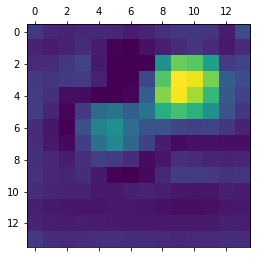

In [41]:
# draw the heatmap
plt.matshow(heatmap.squeeze())

In [43]:
import cv2
img = cv2.imread('./data/Elephant/ElephantImage.jpeg')
print(img.shape[1], img.shape[0])

419 280


In [0]:
heatmap = cv2.resize(np.float32(heatmap), (img.shape[1], img.shape[0]))

In [46]:
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = heatmap * 0.4 + img
cv2.imwrite('./map.jpg', superimposed_img)

True

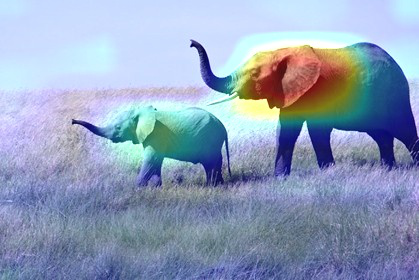

In [49]:
Image.open('./map.jpg')

In [0]:
!mv cam_1.jpg ./data/Elephant

In [56]:
# get the image from the dataloader
img, _ = next(iter(dataloader))
# get the most likely prediction of the model
pred_idx = vgg(img).argmax(dim=1)
print(pred_idx)

# get the gradient of the output with respect to the parameters of the model
pred = vgg(img)
pred[:, pred_idx].backward()


tensor([386])
